In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# 한글 깨짐 방지
import koreanize_matplotlib

#Time Series Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# clustering
from sklearn.cluster import KMeans

# 모델링
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 시스템
from tqdm.notebook import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

2023-10-30 07:27:05.666897: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-30 07:27:05.706907: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-30 07:27:05.706952: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-30 07:27:05.706981: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-30 07:27:05.714034: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-30 07:27:05.714547: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
train_61_M = pd.read_csv('61번_MAIN.csv', encoding = 'cp949')
train_61_1 = pd.read_csv('61번_파트1.csv', encoding = 'cp949')
train_61_2 = pd.read_csv('61번_파트2.csv', encoding = 'cp949')

In [3]:
train_61_M.head()

,일시,전력사용량
0,2021-10-20,42783392
1,2021-10-20 오전 1:00:00,42787024
2,2021-10-20 오전 2:00:00,42790732
3,2021-10-20 오전 3:00:00,42794400
4,2021-10-20 오전 4:00:00,42798000


# 데이터 합병 및 시계열 데이터 변환

In [4]:
train_61 = pd.merge(train_61_M, train_61_1, on = '일시')
train_61 = pd.merge(train_61, train_61_2, on = '일시')
train_61.columns = ['일시', '전력사용량(Main)', '전력사용량(Part1)', '전력사용량(Part2)']

In [5]:
train_61.loc[0::24, '일시'] = train_61.loc[0::24, '일시'] + ' 오전 0:00:00'

In [6]:
train_61['시간'] = pd.to_datetime(train_61['일시'].str.split(' ').str[0] + ' ' + train_61['일시'].str.split(' ').str[2], format = '%Y-%m-%d %H')

In [7]:
for i in range(len(train_61)):
    if (train_61.loc[i, '일시'].split(' ')[1] == '오후') and (train_61.loc[i, '일시'].split(' ')[2] != '12:00:00'):
        train_61.loc[i, '시간'] = train_61.loc[i, '시간'] + pd.to_timedelta(12, unit='H')

In [8]:
train_61.drop('일시', axis = 1, inplace = True)
train_61 = train_61.reindex(columns=['시간', '전력사용량(Main)', '전력사용량(Part1)', '전력사용량(Part2)'])

In [9]:
li_M = [np.nan]
li_1 = [np.nan]
li_2 = [np.nan]
for i in range(len(train_61)-1):
    li_M.append(train_61.loc[i+1, '전력사용량(Main)'] - train_61.loc[i, '전력사용량(Main)'])
    li_1.append(train_61.loc[i+1, '전력사용량(Part1)'] - train_61.loc[i, '전력사용량(Part1)'])
    li_2.append(train_61.loc[i+1, '전력사용량(Part2)'] - train_61.loc[i, '전력사용량(Part2)'])

train_61['전력사용량_M(real)'] = pd.DataFrame(li_M)
train_61['전력사용량_1(real)'] = pd.DataFrame(li_1)
train_61['전력사용량_2(real)'] = pd.DataFrame(li_2)

In [10]:
def datetime_chage(df):
    # 5, 6 주말
    df['month'] = df['시간'].dt.month
    df['hour'] = df['시간'].dt.hour
    df['weekday'] = df['시간'].dt.weekday
    df['day'] = df['시간'].dt.day

    # hour는 0~23이기 때문에 비슷한 시간이여도 멀게 느껴지기 때문에 sin, cosin 함수를 활용해 변환하여 순환적인 성격을 반영한다.
    df['sin_time'] = np.sin(2*np.pi*df.hour/24)
    df['cos_time'] = np.cos(2*np.pi*df.hour/24)

datetime_chage(train_61)

In [11]:
train_61['holiday'] = train_61.apply(lambda x : 0 if x['weekday']<5 else 1, axis = 1)

In [12]:
train_61

,시간,전력사용량(Main),전력사용량(Part1),전력사용량(Part2),전력사용량_M(real),전력사용량_1(real),전력사용량_2(real),month,hour,weekday,day,sin_time,cos_time,holiday
0,2021-10-20 00:00:00,42783392,9.334835e+06,31438992,NaN,NaN,NaN,10,0,2,20,0.000000,1.000000,0
1,2021-10-20 01:00:00,42787024,9.337298e+06,31440164,3632.0,2463.0000,1172.0,10,1,2,20,0.258819,0.965926,0
2,2021-10-20 02:00:00,42790732,9.339817e+06,31441352,3708.0,2519.0000,1188.0,10,2,2,20,0.500000,0.866025,0
3,2021-10-20 03:00:00,42794400,9.342287e+06,31442548,3668.0,2470.0000,1196.0,10,3,2,20,0.707107,0.707107,0
4,2021-10-20 04:00:00,42798000,9.344706e+06,31443736,3600.0,2419.0000,1188.0,10,4,2,20,0.866025,0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2021-10-30 19:00:00,33987524,1.603617e+05,31790478,3664.0,2664.2500,1002.0,10,19,5,30,-0.965926,0.258819,1
260,2021-10-30 20:00:00,33991024,1.629556e+05,31791390,3500.0,2593.8906,912.0,10,20,5,30,-0.866025,0.500000,1
261,2021-10-30 21:00:00,33994408,1.654548e+05,31792268,3384.0,2499.2657,878.0,10,21,5,30,-0.707107,0.707107,1
262,2021-10-30 22:00:00,33997836,1.679975e+05,31793152,3428.0,2542.6250,884.0,10,22,5,30,-0.500000,0.866025,1


# 시간에 따른 전력사용량 확인

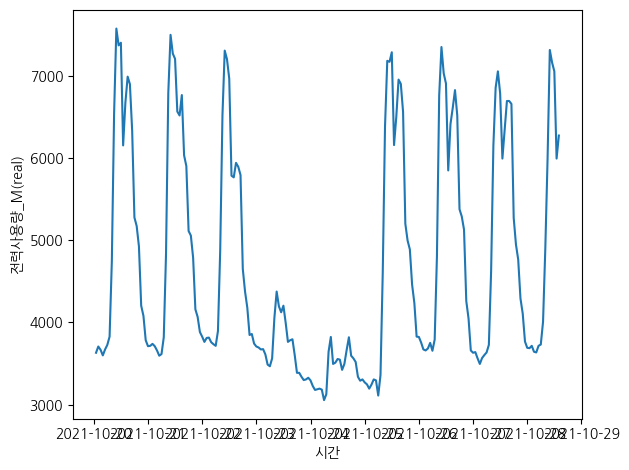

In [13]:
fig = plt.figure()
ax = fig.add_subplot()
ax = sns.lineplot(x='시간',
                    y='전력사용량_M(real)', data = train_61[:207])

fig.tight_layout()
plt.show()

In [14]:
train_61[(train_61['holiday'] == 0) & (train_61['hour'] == 15)]

,시간,전력사용량(Main),전력사용량(Part1),전력사용량(Part2),전력사용량_M(real),전력사용량_1(real),전력사용량_2(real),month,hour,weekday,day,sin_time,cos_time,holiday
15,2021-10-20 15:00:00,42862668,9.387409e+06,31462628,6988.0,4.608000e+03,1782.0,10,15,2,20,-0.707107,-0.707107,0
39,2021-10-21 15:00:00,42986344,9.470446e+06,31498744,6764.0,4.397000e+03,1766.0,10,15,3,21,-0.707107,-0.707107,0
63,2021-10-22 15:00:00,43106024,9.552113e+06,31534808,5940.0,4.304000e+03,1632.0,10,15,4,22,-0.707107,-0.707107,0
135,2021-10-25 15:00:00,43391528,9.758545e+06,31611150,6952.0,4.453000e+03,1936.0,10,15,0,25,-0.707107,-0.707107,0
159,2021-10-26 15:00:00,43514104,9.839853e+06,31648858,6608.0,4.408000e+03,1864.0,10,15,1,26,-0.707107,-0.707107,0
183,2021-10-27 15:00:00,43634552,9.920166e+06,31686112,6692.0,4.343000e+03,1742.0,10,15,2,27,-0.707107,-0.707107,0
207,2021-10-28 15:00:00,33756400,1.557807e+03,31723048,-9993152.0,-9.995482e+06,1756.0,10,15,3,28,-0.707107,-0.707107,0
231,2021-10-29 15:00:00,33878656,8.380542e+04,31759162,6640.0,4.373344e+03,1688.0,10,15,4,29,-0.707107,-0.707107,0


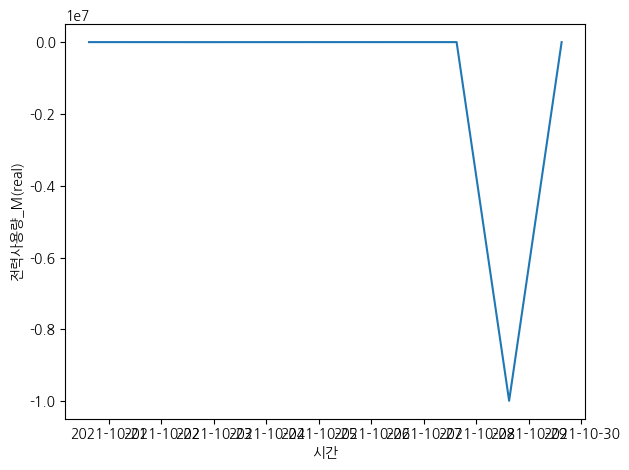

In [15]:
fig = plt.figure()
ax = fig.add_subplot()
ax = sns.lineplot(x='시간',
                    y='전력사용량_M(real)', data = train_61[(train_61['holiday'] == 0) & (train_61['hour'] == 15)])

fig.tight_layout()
plt.show()

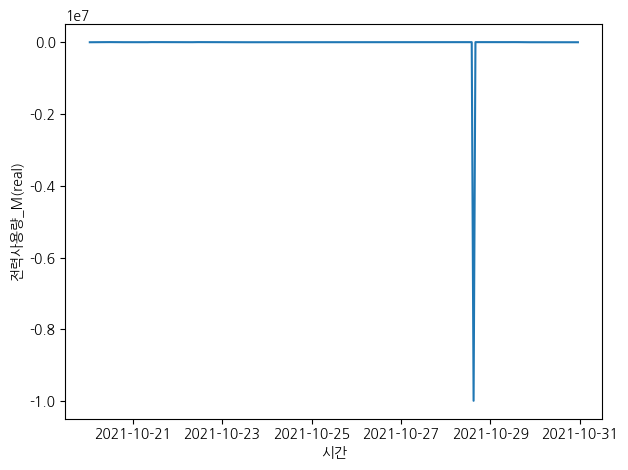

In [16]:
fig = plt.figure()
ax = fig.add_subplot()
ax = sns.lineplot(x='시간',
                    y='전력사용량_M(real)', data = train_61)

fig.tight_layout()
plt.show()

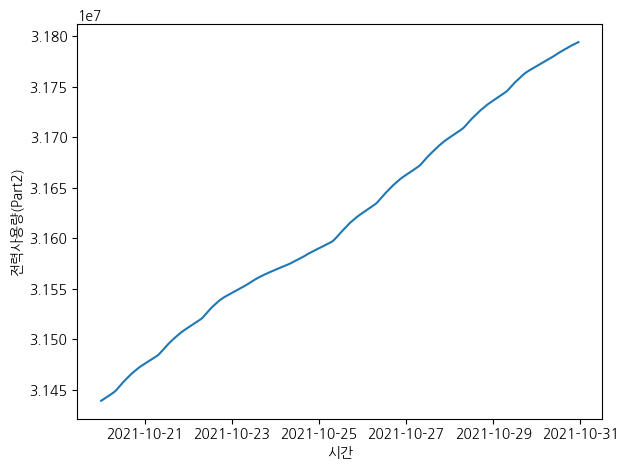

In [17]:
fig = plt.figure()
ax = fig.add_subplot()
ax = sns.lineplot(x='시간',
                    y='전력사용량(Part2)', data = train_61)

fig.tight_layout()
plt.show()

# 이상치

In [18]:
train_61['전력사용량(Part1)'].max() - train_61['전력사용량(Part1)'].min()

9995482.192993

In [19]:
train_61['전력사용량(Main)'].max() - train_61['전력사용량(Main)'].min()

9993152

In [20]:
train_61.loc[207, '전력사용량_1(real)'] = (train_61.loc[183, '전력사용량_1(real)'] + train_61.loc[231, '전력사용량_1(real)'])/2
train_61.loc[207, '전력사용량_M(real)'] = (train_61.loc[207, '전력사용량_1(real)'] + train_61.loc[207, '전력사용량_2(real)'])

# 결측치

In [21]:
train_61[train_61['전력사용량_M(real)'].isna()]

,시간,전력사용량(Main),전력사용량(Part1),전력사용량(Part2),전력사용량_M(real),전력사용량_1(real),전력사용량_2(real),month,hour,weekday,day,sin_time,cos_time,holiday
0,2021-10-20,42783392,9334835.0,31438992,NaN,NaN,NaN,10,0,2,20,0.0,1.0,0


In [22]:
train_61[(train_61['hour'] == 0) & (train_61['holiday'] == 0)]

,시간,전력사용량(Main),전력사용량(Part1),전력사용량(Part2),전력사용량_M(real),전력사용량_1(real),전력사용량_2(real),month,hour,weekday,day,sin_time,cos_time,holiday
0,2021-10-20,42783392,9.334835e+06,31438992,NaN,NaN,NaN,10,0,2,20,0.0,1.0,0
24,2021-10-21,42907048,9.418114e+06,31475644,3712.0,2575.00000,1138.0,10,0,3,21,0.0,1.0,0
48,2021-10-22,43029172,9.500411e+06,31511582,3828.0,2625.00000,1202.0,10,0,4,22,0.0,1.0,0
120,2021-10-25,43316536,9.707446e+06,31589988,3272.0,2365.00000,908.0,10,0,0,25,0.0,1.0,0
144,2021-10-26,43436420,9.788965e+06,31624900,3824.0,2594.00000,1230.0,10,0,1,26,0.0,1.0,0
168,2021-10-27,43558836,9.869981e+06,31662564,3632.0,2439.00000,1192.0,10,0,2,27,0.0,1.0,0
192,2021-10-28,43678744,9.949936e+06,31699590,3692.0,2485.00000,1206.0,10,0,3,28,0.0,1.0,0
216,2021-10-29,33801588,3.273093e+04,31736166,3832.0,2598.27539,1232.0,10,0,4,29,0.0,1.0,0


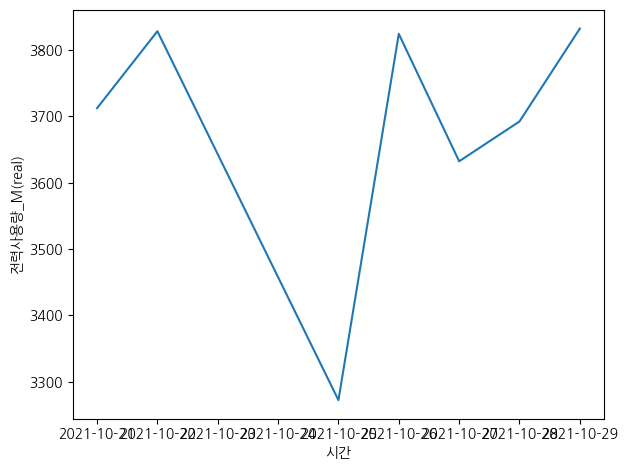

In [23]:
fig = plt.figure()
ax = fig.add_subplot()
ax = sns.lineplot(x='시간',
                    y='전력사용량_M(real)', data = train_61[(train_61['hour'] == 0) & (train_61['holiday'] == 0)])

fig.tight_layout()
plt.show()

In [24]:
train_61[(train_61['hour'] == 0) & (train_61['holiday'] == 0)]['전력사용량_M(real)'].mean()

3684.5714285714284

In [25]:
train_61[train_61['전력사용량_2(real)'].isna()].index

Int64Index([0], dtype='int64')

In [26]:
train_61.loc[train_61[train_61['전력사용량_1(real)'].isna()].index, '전력사용량_1(real)'] = train_61[(train_61['hour'] == 0) & (train_61['holiday'] == 0)]['전력사용량_1(real)'].mean()
train_61.loc[train_61[train_61['전력사용량_2(real)'].isna()].index, '전력사용량_2(real)'] = train_61[(train_61['hour'] == 0) & (train_61['holiday'] == 0)]['전력사용량_2(real)'].mean()
train_61.loc[train_61[train_61['전력사용량_M(real)'].isna()].index, '전력사용량_M(real)'] = train_61.loc[train_61[train_61['전력사용량_M(real)'].isna()].index, '전력사용량_1(real)'] + train_61.loc[train_61[train_61['전력사용량_M(real)'].isna()].index, '전력사용량_2(real)']

In [27]:
train_61

,시간,전력사용량(Main),전력사용량(Part1),전력사용량(Part2),전력사용량_M(real),전력사용량_1(real),전력사용량_2(real),month,hour,weekday,day,sin_time,cos_time,holiday
0,2021-10-20 00:00:00,42783392,9.334835e+06,31438992,3684.571429,2525.896484,1158.285714,10,0,2,20,0.000000,1.000000,0
1,2021-10-20 01:00:00,42787024,9.337298e+06,31440164,3632.000000,2463.000000,1172.000000,10,1,2,20,0.258819,0.965926,0
2,2021-10-20 02:00:00,42790732,9.339817e+06,31441352,3708.000000,2519.000000,1188.000000,10,2,2,20,0.500000,0.866025,0
3,2021-10-20 03:00:00,42794400,9.342287e+06,31442548,3668.000000,2470.000000,1196.000000,10,3,2,20,0.707107,0.707107,0
4,2021-10-20 04:00:00,42798000,9.344706e+06,31443736,3600.000000,2419.000000,1188.000000,10,4,2,20,0.866025,0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2021-10-30 19:00:00,33987524,1.603617e+05,31790478,3664.000000,2664.250000,1002.000000,10,19,5,30,-0.965926,0.258819,1
260,2021-10-30 20:00:00,33991024,1.629556e+05,31791390,3500.000000,2593.890600,912.000000,10,20,5,30,-0.866025,0.500000,1
261,2021-10-30 21:00:00,33994408,1.654548e+05,31792268,3384.000000,2499.265700,878.000000,10,21,5,30,-0.707107,0.707107,1
262,2021-10-30 22:00:00,33997836,1.679975e+05,31793152,3428.000000,2542.625000,884.000000,10,22,5,30,-0.500000,0.866025,1


# 시계열 분해

In [28]:
def vis_time_series_decompose(df, col_name):
    df.index = df.시간

    res = sm.tsa.seasonal_decompose(df[col_name], model='additive')

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
    res.observed.plot(ax=ax1, title='Observed')
    res.trend.plot(ax=ax2, title='Trend')
    res.resid.plot(ax=ax3, title='Residual')
    res.seasonal.plot(ax=ax4, title='Seasonal')
    plt.tight_layout()
    plt.show()

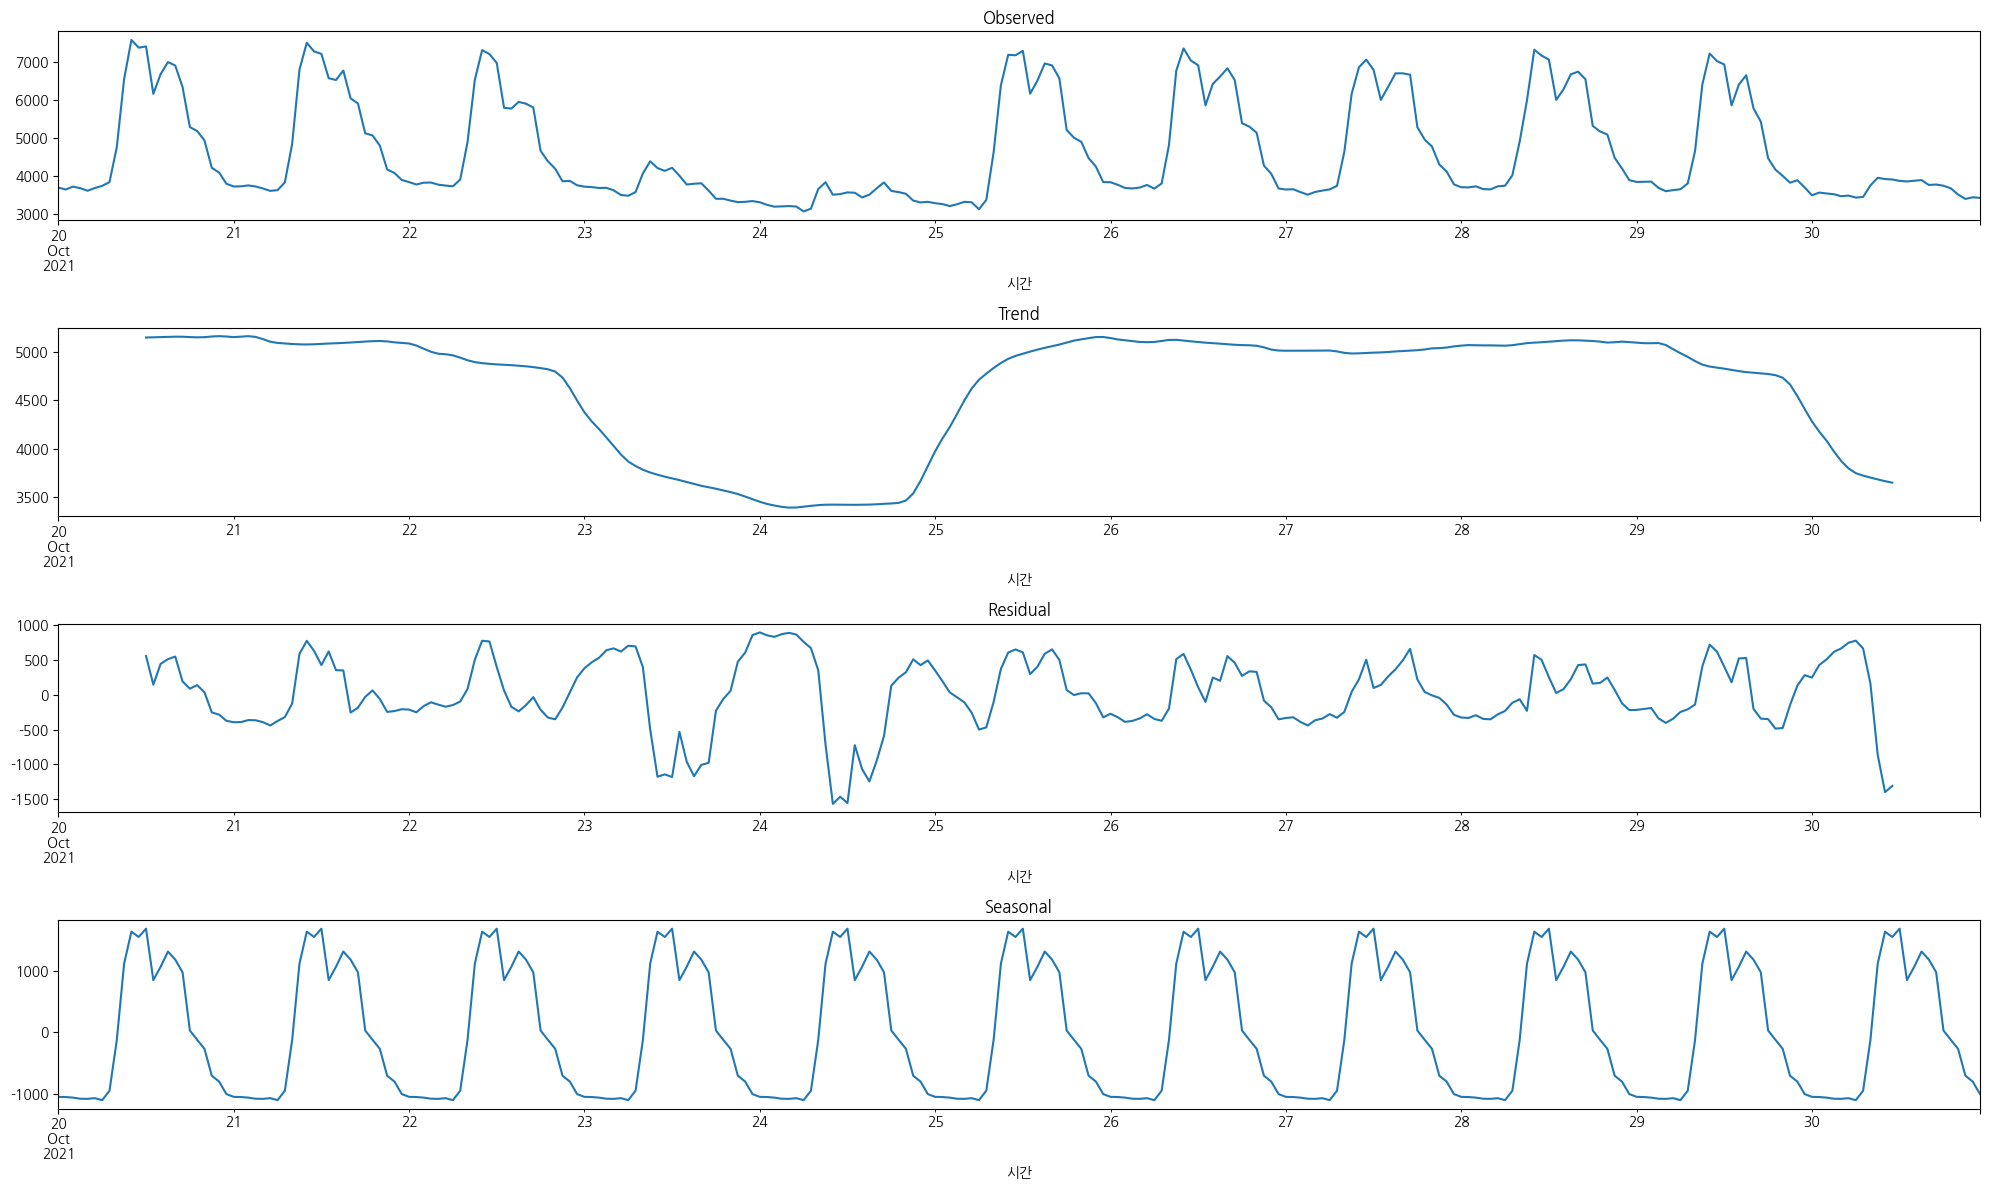

In [29]:
vis_time_series_decompose(train_61, '전력사용량_M(real)')

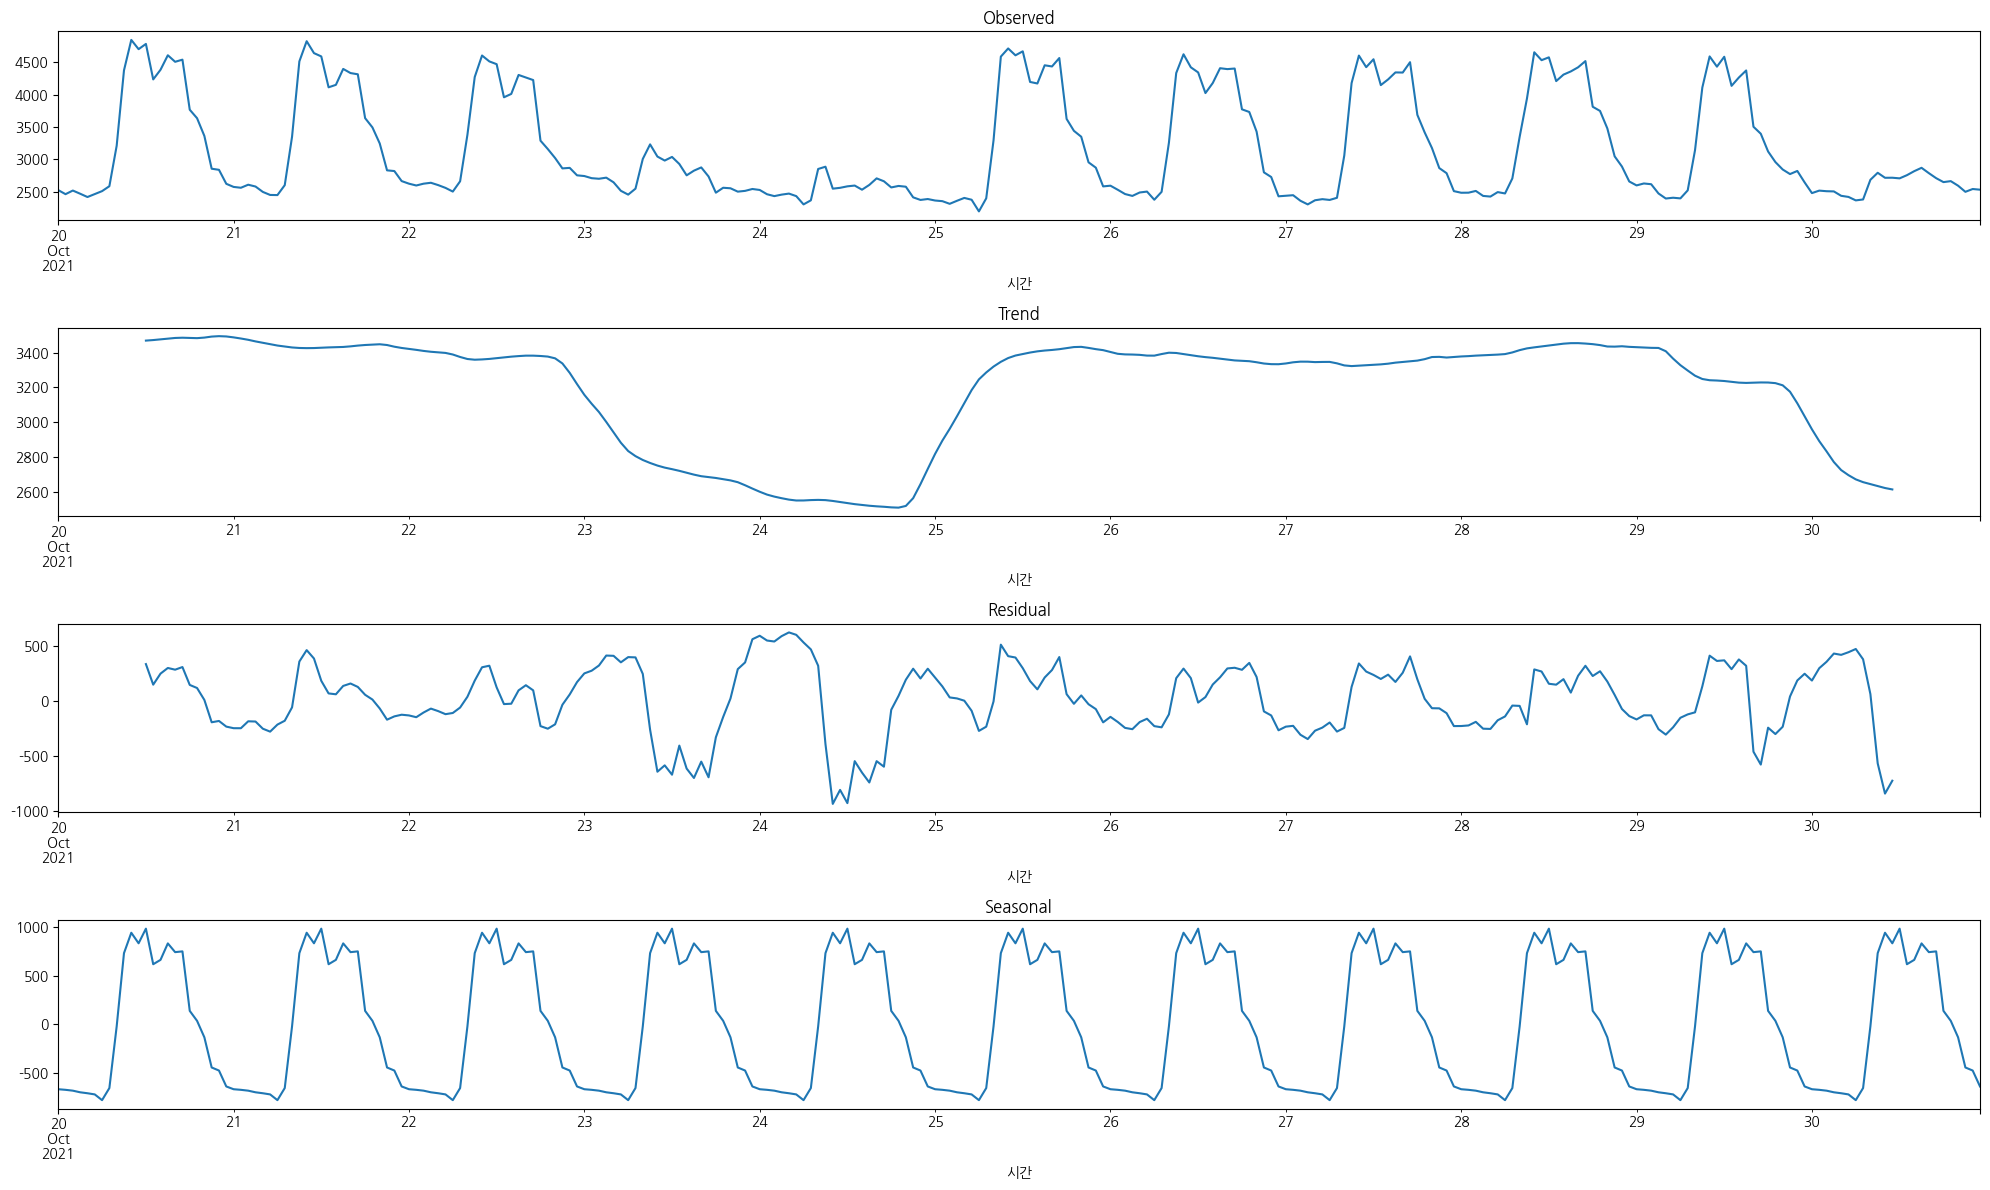

In [30]:
vis_time_series_decompose(train_61, '전력사용량_1(real)')

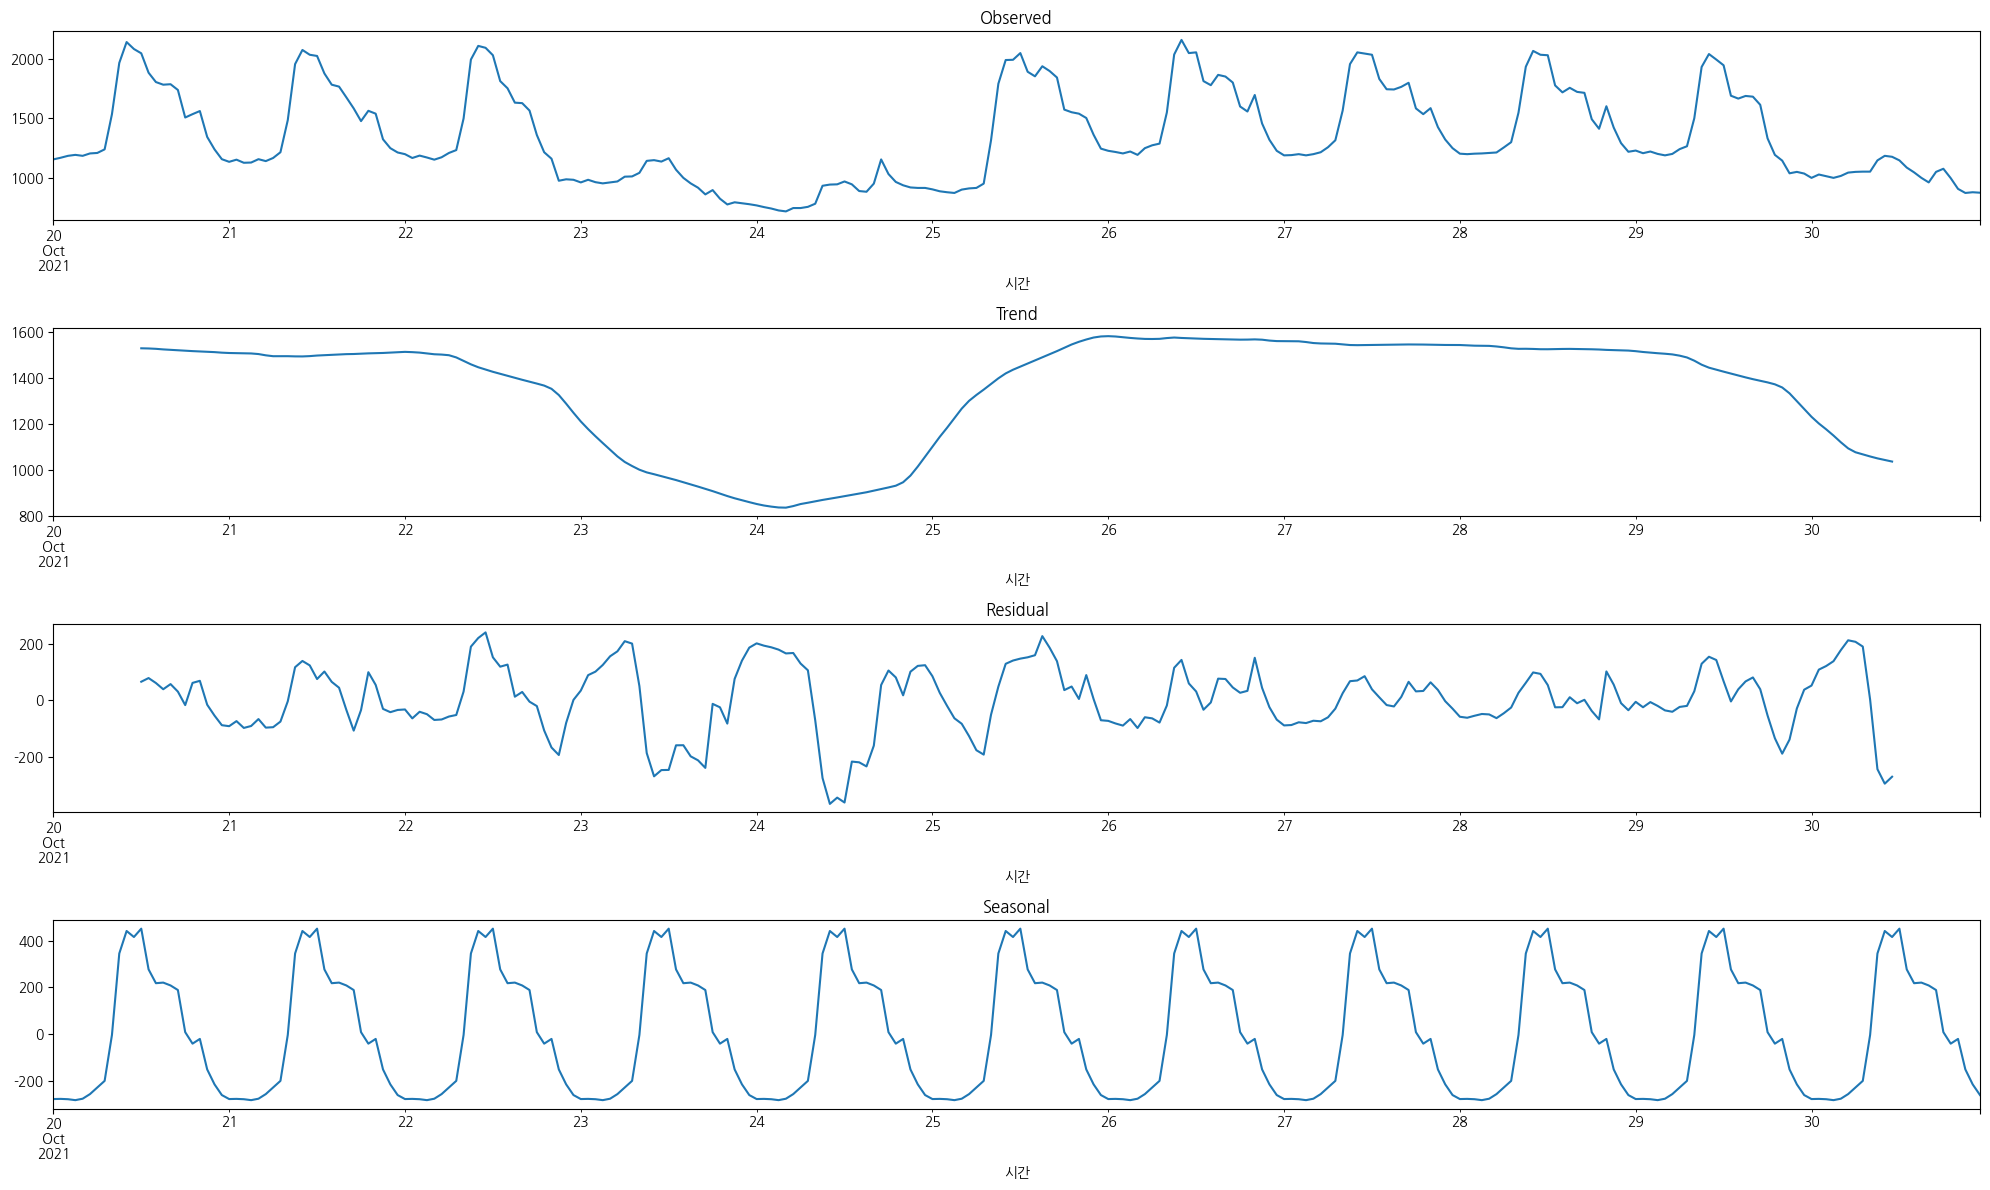

In [31]:
vis_time_series_decompose(train_61, '전력사용량_2(real)')

In [32]:
decomposed = sm.tsa.seasonal_decompose(train_61['전력사용량_M(real)'], model='additive', period = 24)
print('Main 전력사용량')
print('추세 강도 : ', 1 - (decomposed.resid.std() / (decomposed.resid + decomposed.trend).std()))
print('계절성 강도 : ', 1 - (decomposed.resid.std() / (decomposed.resid + decomposed.seasonal).std()))

Main 전력사용량
추세 강도 :  0.38761215624831447
계절성 강도 :  0.5684773802962247


In [33]:
decomposed = sm.tsa.seasonal_decompose(train_61['전력사용량_1(real)'], model='additive', period = 24)
print('Part1 전력사용량')
print('추세 강도 : ', 1 - (decomposed.resid.std() / (decomposed.resid + decomposed.trend).std()))
print('계절성 강도 : ', 1 - (decomposed.resid.std() / (decomposed.resid + decomposed.seasonal).std()))

Part1 전력사용량
추세 강도 :  0.32259724013660784
계절성 강도 :  0.5679194060937558


In [34]:
decomposed = sm.tsa.seasonal_decompose(train_61['전력사용량_2(real)'], model='additive', period = 24)
print('Part2 전력사용량')
print('추세 강도 : ', 1 - (decomposed.resid.std() / (decomposed.resid + decomposed.trend).std()))
print('계절성 강도 : ', 1 - (decomposed.resid.std() / (decomposed.resid + decomposed.seasonal).std()))

Part2 전력사용량
추세 강도 :  0.5783805222564193
계절성 강도 :  0.5892657785122177


# 자기상관, 부분자기상관

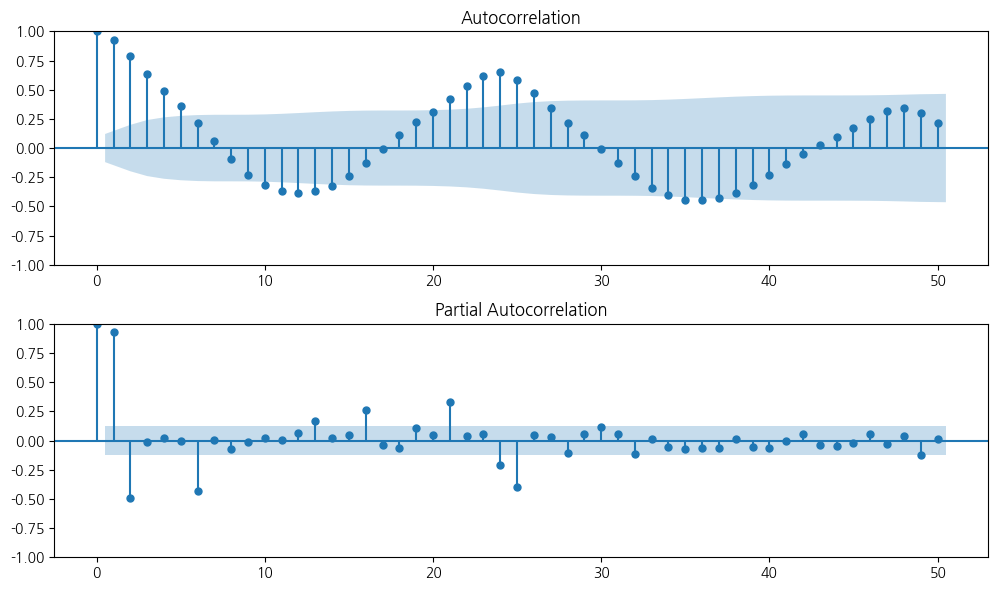

In [35]:
df = train_61
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df['전력사용량_M(real)'], lags=50, ax=ax1)
plot_pacf(df['전력사용량_M(real)'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

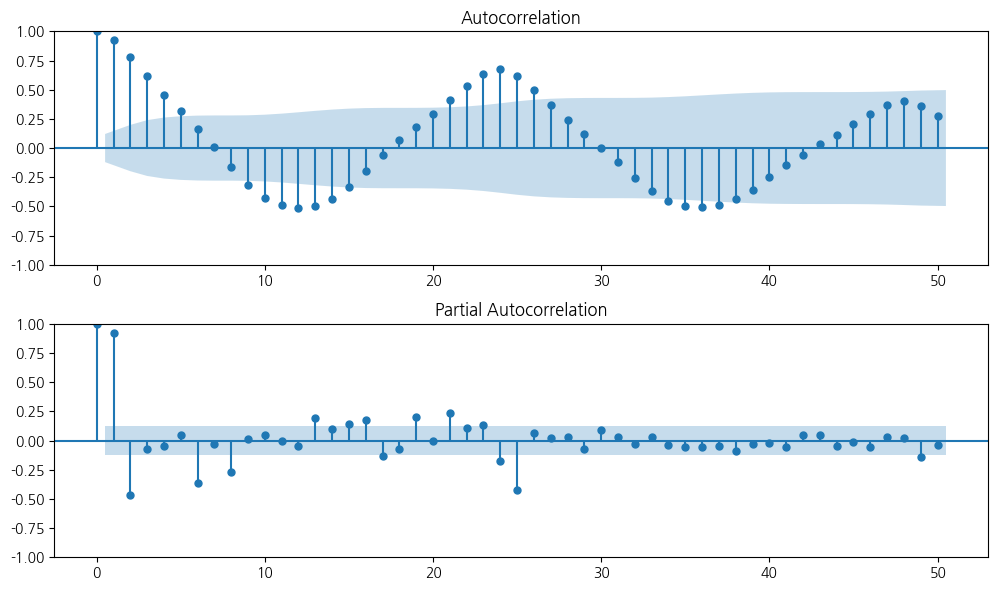

In [36]:
df = train_61
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df['전력사용량_1(real)'], lags=50, ax=ax1)
plot_pacf(df['전력사용량_1(real)'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

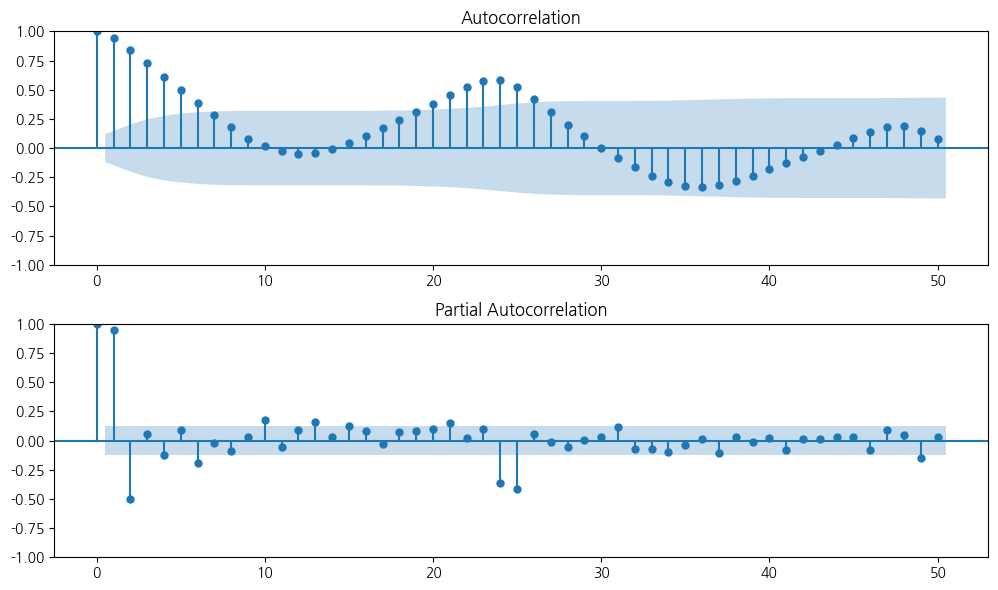

In [37]:
df = train_61
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df['전력사용량_2(real)'], lags=50, ax=ax1)
plot_pacf(df['전력사용량_2(real)'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

In [ ]:
# 3번 지역과 비슷함